# Name: Luke Pratley

# Testing Basic UNet

In [22]:
%load_ext nb_black
%load_ext tensorboard
import tensorflow.keras 
import tensorflow as tf

import tensorboard

from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import PIL
import math

import sys
import glob
import os

from sklearn.model_selection import train_test_split

sys.path.append('..')

import building_road_segmentation.unet_factory as unet_factory
import building_road_segmentation.optimization_factory as optimization_factory
import building_road_segmentation.data_generator as data_generator

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [2]:
image_dir =  glob.glob("..\\data_cleaning_EDA\\final_images_small\\*")
mask_dir =  glob.glob("..\\data_cleaning_EDA\\final_masks_small\\*")
for p in range(len(image_dir)):
    s1 = image_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.png', '')
    s2 = mask_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.npy', '')
    assert s1 == s2

<IPython.core.display.Javascript object>

In [3]:
train_image_dir, test_image_dir, train_mask_dir, test_mask_dir = train_test_split(image_dir, mask_dir, test_size=0.3)

<IPython.core.display.Javascript object>

In [4]:
train_data = data_generator.READ_AND_AUGMENT_DATA(train_image_dir, train_mask_dir, batch_size=64)
test_data = data_generator.READ_DATA(test_image_dir, test_mask_dir, batch_size=128)

<IPython.core.display.Javascript object>

In [23]:
model_configurations = {'model_1': {'unet_levels': 3, 'number_of_start_kernels': 16, 'pooling_amount': 2},
                        'model_2': {'unet_levels': 4, 'number_of_start_kernels': 16, 'pooling_amount': 2},
                        'model_3': {'unet_levels': 5, 'number_of_start_kernels': 16, 'pooling_amount': 2},
                        'model_4': {'unet_levels': 3, 'number_of_start_kernels': 32, 'pooling_amount': 2},
                        'model_5': {'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2},
                        'model_6': {'unet_levels': 5, 'number_of_start_kernels': 32, 'pooling_amount': 2},
                       }
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_iou_metric = tf.keras.metrics.MeanIoU(num_classes=3)




False

<IPython.core.display.Javascript object>

In [7]:
for model_name, model_config in model_configurations.items():
    if not os.path.exists(model_name):
        unet_model = unet_factory.BasicUnet(number_of_categories=3,
                                            unet_levels=model_config['unet_levels'],
                                            number_of_start_kernels=model_config['number_of_start_kernels'],
                                            kernel_shape=(3, 3),
                                            activation='relu',
                                            pooling_amount=model_config['pooling_amount'],
                                            dropout_rate=0.2)

        modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, 
                        monitor='val_accuracy',
                        mode='max',
                        save_best_only=True, initial_value_threshold=0.7)
        unet_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
        history = unet_model.fit(train_data, epochs=100, validation_data=test_data, callbacks=[modelcheckpoint])
        history = pd.DataFrame(history.history) 
        history.to_csv(f'{model_name}_history.csv')  

Epoch 1/100
262/262 [==============================] - 65s 245ms/step - loss: 0.7487 - accuracy: 0.6489 - val_loss: 0.8829 - val_accuracy: 0.5967
INFO:tensorflow:Assets written to: model_1\assets
Epoch 2/100
262/262 [==============================] - 63s 239ms/step - loss: 0.6445 - accuracy: 0.7089 - val_loss: 0.6871 - val_accuracy: 0.6861
INFO:tensorflow:Assets written to: model_1\assets
Epoch 3/100
262/262 [==============================] - 63s 239ms/step - loss: 0.6129 - accuracy: 0.7258 - val_loss: 0.5887 - val_accuracy: 0.7399
INFO:tensorflow:Assets written to: model_1\assets
Epoch 4/100
262/262 [==============================] - 66s 253ms/step - loss: 0.5956 - accuracy: 0.7347 - val_loss: 0.5813 - val_accuracy: 0.7450
INFO:tensorflow:Assets written to: model_1\assets
Epoch 5/100
262/262 [==============================] - 63s 240ms/step - loss: 0.5812 - accuracy: 0.7423 - val_loss: 0.5674 - val_accuracy: 0.7491
INFO:tensorflow:Assets written to: model_1\assets
Epoch 6/100
262/262 

<IPython.core.display.Javascript object>

In [38]:
import pickle
histories = []
for model_name, model_config in model_configurations.items():
    if os.path.exists(model_name):
        with open(f'{model_name}.pkg', 'rb') as file_pi:
            histories.append(pickle.load(file_pi))
            file_pi.close()
for history in histories:
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

EOFError: Ran out of input

<IPython.core.display.Javascript object>

In [56]:
X_test = np.array([np.array(PIL.Image.open(im)).astype(float)/255 for im in test_image_dir])

<IPython.core.display.Javascript object>

In [57]:
y_test = np.array([
            np.load(file_name)
               for file_name in test_mask_dir])

<IPython.core.display.Javascript object>

In [53]:
for k, (model_name, model_config) in enumerate(model_configurations.items()):
    final_model = tf.keras.models.load_model(model_name)
    print(model_config)
    y_pred = final_model.predict(X_test)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    train_iou_metric.update_state(y_pred, y_test)
    tf.print(train_iou_metric.result())
    train_iou_metric.reset_state()

{'unet_levels': 3, 'number_of_start_kernels': 16, 'pooling_amount': 2}
0.246880621
{'unet_levels': 4, 'number_of_start_kernels': 16, 'pooling_amount': 2}
0.243125856
{'unet_levels': 5, 'number_of_start_kernels': 16, 'pooling_amount': 2}
0.241983294
{'unet_levels': 3, 'number_of_start_kernels': 32, 'pooling_amount': 2}
0.244015932
{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2}
0.242678314
{'unet_levels': 5, 'number_of_start_kernels': 32, 'pooling_amount': 2}
0.243219748


<IPython.core.display.Javascript object>

In [62]:
np.array([X_test[0]]).shape

(1, 128, 128, 3)

<IPython.core.display.Javascript object>

In [80]:
def plot_result(X_test, y_test, model_name, display_prob, index=0):
    final_model = tf.keras.models.load_model(model_name)
    batch_size = 32
    batch = index % batch_size
    y_pred = final_model.predict(X_test[batch_size * batch: batch_size * (batch + 1)])
    if not display_prob:
        y_pred = np.where(y_pred > 0.5, 1, 0)
    fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
    ax[0, 0].imshow((X_test[index - batch_size * batch] * 255).astype(int))
    ax[1, 0].imshow(np.sum(y_test[index, :, :, :2], axis=2), vmin = 0)
    ax[1, 1].imshow(y_test[index - batch_size * batch, :, :, 0], vmin = 0)
    ax[1, 2].imshow(y_test[index - batch_size * batch, :, :, 1], vmin = 0)
    ax[1, 3].imshow(y_test[index - batch_size * batch, :, :, 2], vmin = 0)
    ax[0, 1].imshow(y_pred[index, :, :, 0], vmin = 0)
    ax[0, 2].imshow(y_pred[index, :, :, 1], vmin = 0)
    ax[0, 3].imshow(y_pred[index, :, :, 2], vmin = 0)

<IPython.core.display.Javascript object>

{'unet_levels': 3, 'number_of_start_kernels': 16, 'pooling_amount': 2}


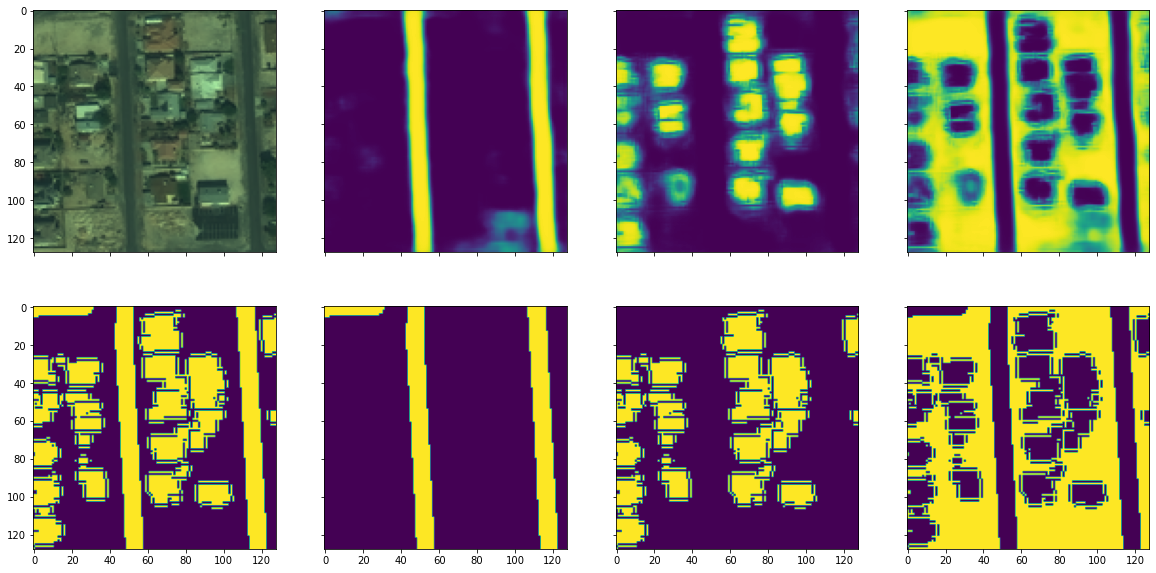

{'unet_levels': 4, 'number_of_start_kernels': 16, 'pooling_amount': 2}


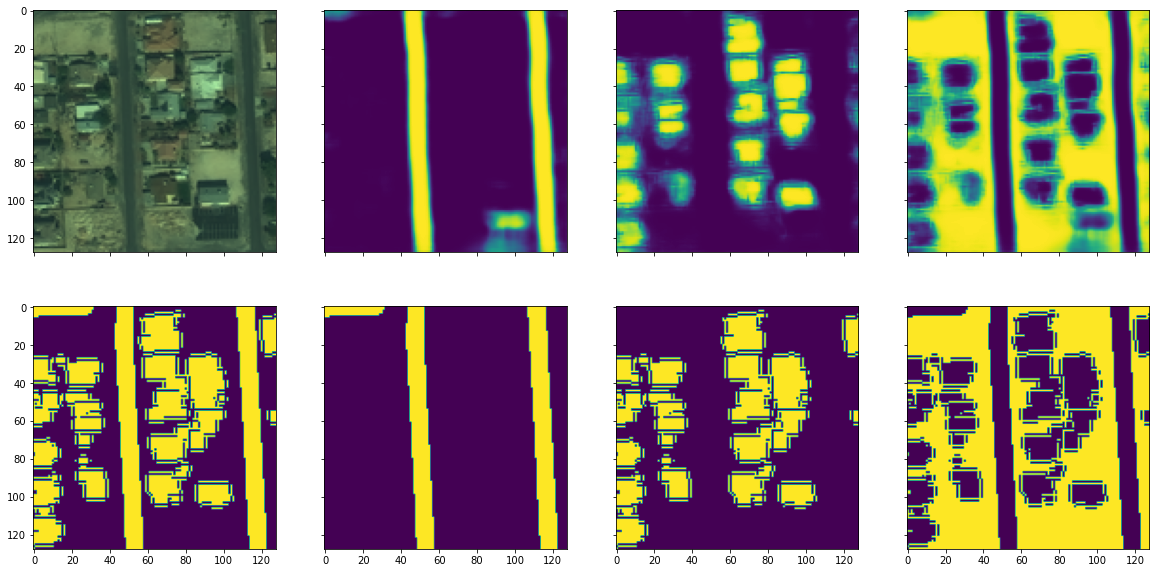

{'unet_levels': 5, 'number_of_start_kernels': 16, 'pooling_amount': 2}


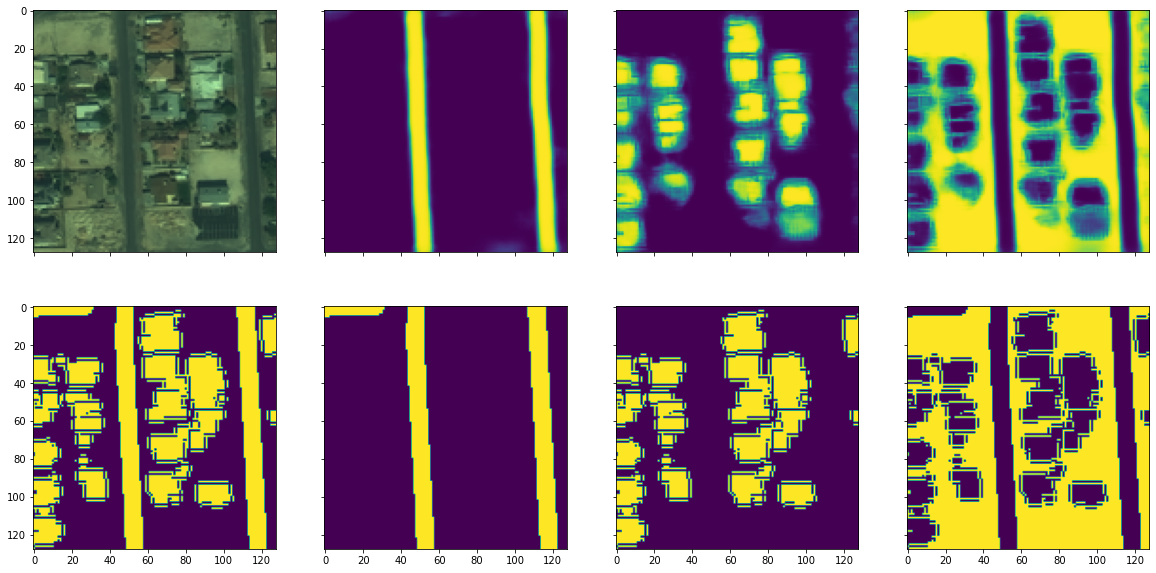

{'unet_levels': 3, 'number_of_start_kernels': 32, 'pooling_amount': 2}


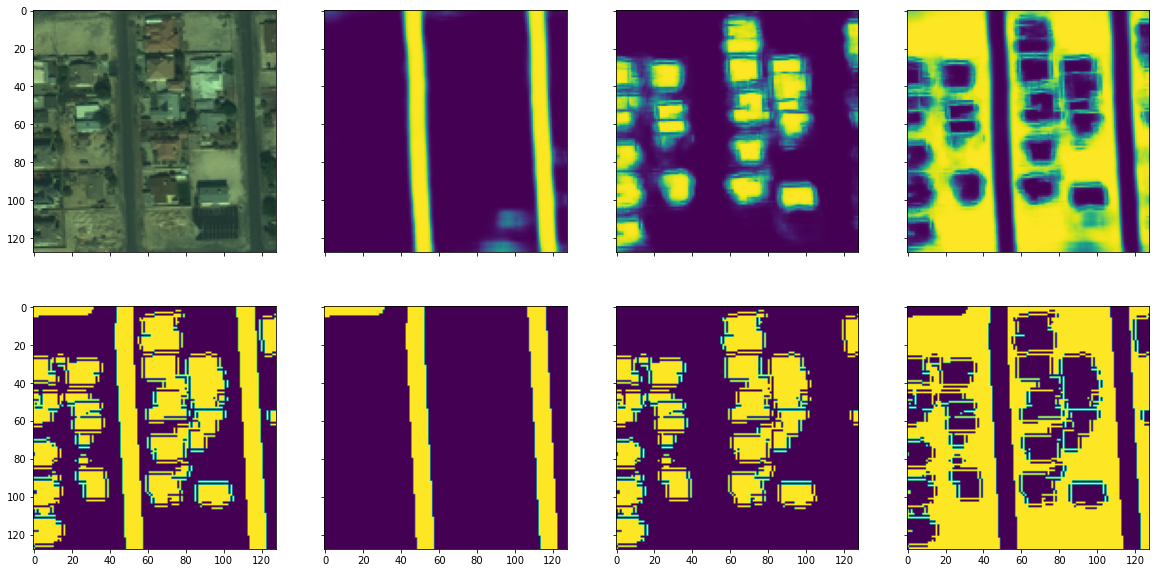

{'unet_levels': 4, 'number_of_start_kernels': 32, 'pooling_amount': 2}


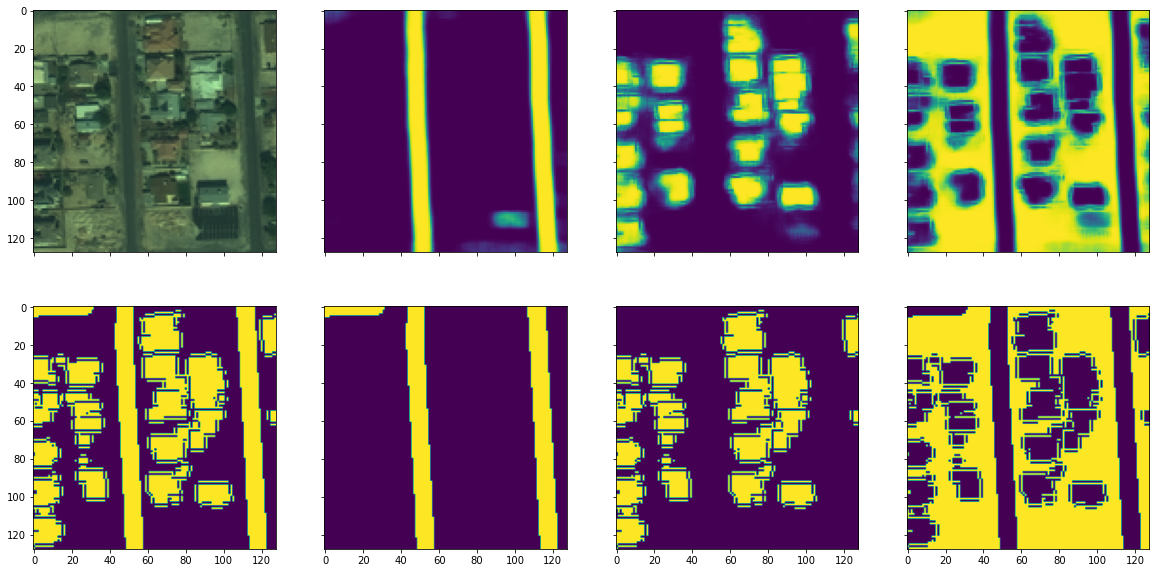

{'unet_levels': 5, 'number_of_start_kernels': 32, 'pooling_amount': 2}


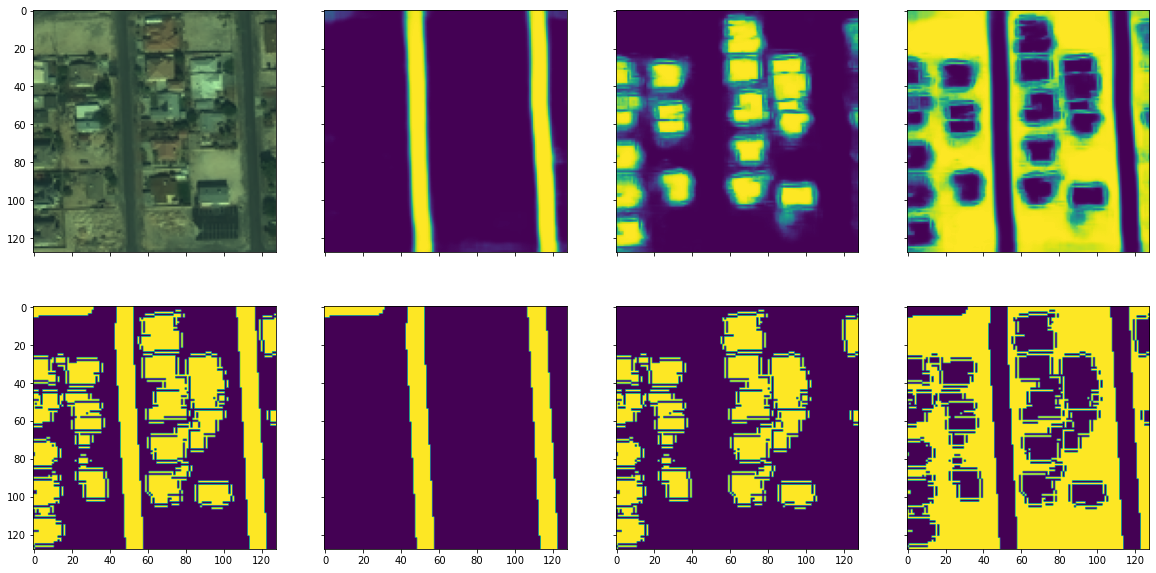

<IPython.core.display.Javascript object>

In [82]:
k = 0
for model_name, model_config in model_configurations.items():
    print(model_config)
    plot_result(X_test, y_test, model_name=model_name, display_prob=True, index=k)
    plt.show()